# Data Preparation and Analysis

In [2]:
import os
path = 'chest_xray'
dirs = os.listdir(path)
train_dir = path + '/train/'
test_dir = path + '/test/'
val_dir = path + '/val/'
train_dirs = os.listdir(train_dir)
norm_train = train_dir + 'NORMAL/'
pnem_train   = train_dir + 'PNEUMONIA/'

In [3]:
from glob import glob
norm_imgs = glob(norm_train + "*.jpeg")
pnem_imgs = glob(pnem_train + "*.jpeg")

In [4]:
import numpy as np
import matplotlib.pyplot as plot

def display_images(image_count):
    
    for img in range(image_count):
        pnem_img   = np.asarray(plot.imread(pnem_imgs[img]))
        norm_img = np.asarray(plot.imread(norm_imgs[img]))

        fig = plot.figure(figsize= (15,15))
        
        pneu_plot = fig.add_subplot(1, 2, 1)
        #plot.imshow(pnem_img, cmap='bone')
        plot.imshow(pnem_img, cmap='gray')
        pneu_plot.set_title('Pneumonia')
        plot.axis('off')
        
        normal_plot = fig.add_subplot(1,2,2)
        plot.imshow(norm_img, cmap='gray')
        normal_plot.set_title('Normal')
        plot.axis('off')
    
        plot.show()

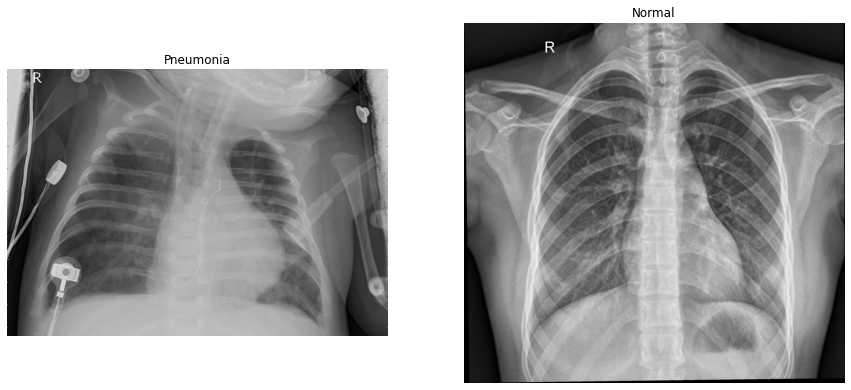

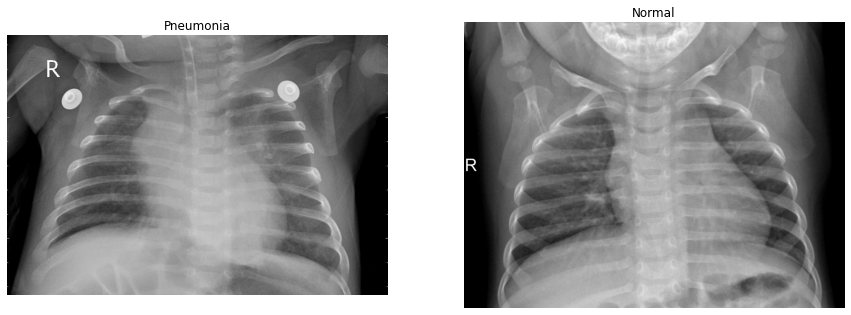

In [5]:
display_images(2)

`ImageDataGenerator()` class from `Keras` is used here for **data augmentation**, or **image processing**, which helps in expanding the training dataset. As more training data is always considered better, it might lead to overfitting but as the model has to generalize more, this seems to become less of a problem.

**Steps:**
- **Rescaling Data**: I rescaled the data as most images have RGB values ranging from 0-255, which are a little too high for the models to handle. Hence by dividing these values by 255, i.e. multiplying these values by `1/255`, each RGB value can be condensed to a value between 0-1, which is easier for the model to process.
- **Shear Mapping**: `shear_range` will randomly apply shear transformations, or mapping to the data, the range will be `0.2` in our case, based on a refrence from this wikipedia [article](https://en.wikipedia.org/wiki/Shear_mapping).
- **Zooming**: For randomly zooming on the images, `zoom_range` to '0.2', which can be a random choice but is coresponding to the sheer mapping in this case.
- **Flipping**: As I chose to randomly flip half of the images, this has been set to `True`.
- **Translation**: Responsible for random translation of images.
    - **Height**: `height_shift_range` is used for random height translation
    - **Weight**: `widht_shift_range` is used for random width translation
- **Rotation**: The value in degrees for which the images can be randomly rotated is set in `rotation_range`.

The test set will be rescaled aswell, as it does not need all of the same transformations applied to the training data.

This has been done as test set/data can't be manipulated to avoid overfitting as the training data does.

The test set has to be the original images inorder to accurately predict pneumonia in real world,life. So the manipulation must be kept minimal or none if possible.

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rescale            = 1/255,
                                    zoom_range         = 0.2,
                                    shear_range        = 0.2,
                                    horizontal_flip    = True,
                                    width_shift_range  = 0.2,
                                    height_shift_range = 0.2,
                                    rotation_range     = 40)

test_data_gen = ImageDataGenerator(rescale = 1/255)

Using TensorFlow backend.


**Generating brances of augmented data**: This can be done by passing paths of our folders into `flow_from_directory()` from `Keras`.

- **Arguments**:
    - 1.  directory to fetch from.
    - 2. `target size` is used to set the dimensions of the images after they are resized.
    - 3. `batch_size` used to set the size of individual batches.
    - 4. `class_mode` is set to `'binary'` to return 1D binary labels.

In [7]:
training_set = train_data_gen.flow_from_directory(train_dir,
                                   target_size= (64, 64),
                                   batch_size = 32,
                                   class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [8]:
validation_set = test_data_gen.flow_from_directory(val_dir,
                                   target_size=(64, 64),
                                   batch_size = 32,
                                   class_mode ='binary')

Found 16 images belonging to 2 classes.


In [9]:
test_set = test_data_gen.flow_from_directory(test_dir,
                                   target_size= (64, 64),
                                   batch_size = 32,
                                   class_mode = 'binary')

Found 624 images belonging to 2 classes.


# Applying CNNs to Predict Pneumonia
[Keras](https://keras.io/) will be the deep learning library of choice for this project, few required layers and models to make the convolutional neural network work(CNN) have been imported from it.

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, BatchNormalization, Dropout

model = Sequential()

After creating a model using the "Sequential" model from Keras, which is a linear stack of layers, meaning that our model will be created layer by layer.

#### 1st Convolutional Layer :
The first convolutional layer is the input layer in our case. 

- Parameters:
    - 1st comes the **amount of convolutional filters** to be used in the layer, which is set to`'32'` and is also the number of neurons, or nodes, that will be in this layer.
    
    - 2nd comes the **filter's size**, or the receptive field. A window that our convolutional layer is restricted to looking through at any given time.
    
    - 3rd parameter will set the **activation function**. 
        - `ReLu`, rectified linear unit, is a nonlinear activation function. The ReLu function is `f(x) = max(0, x)`. Therefore, all negatives are converted to zeros while all positives remain the same. ReLu is not perfect, but it will get the job done for most apps, as it reduces the vanishing gradient issue and is computationally cheaper to compute.
    
    - 4th  parameter is the **input shape**, which only needs to be specified in the first convolutional layer as after the first layer, our model can handle the rest. The input shape is simply the shape of the images that will be fed to the CNN. The shape of our input images will be (64, 64, 3) (width, height, depth).
    
    - 5th parameter is the **padding**, which is set to "same" which will pad the input in a way that makes the output have the same length as the initial input.
    
#### 1st Max Pooling Layer : 
The max pooling layers have only one parameter for this model. The parameter is the **pool size**, or the factor to downscale the input's spatial dimensions. The pool size will be set to (2, 2), which will downscale by half each time.

#### 2nd Convolutional and Max Pooling Layer : 
The second convolutional layer and max pooling layer will be the same as the previous layers above. The second convolutional layer will not need the input size to be specified.

#### 3rd Convolutional Layer :
In the third convolutional layer, the first parameter will be changed. In the first two convolutional layers, the number of filters, or neurons in the layer, was set to `"32"`, but for the thrid layer it will be set to `"64"`. Other than this one change, everything else will stay the same.
#### 3rd Max Pooling Layer : 
The third max pooling layer will be the same as the first two previous pooling layers.

- **Flatten**: Flattening converts multi-dimensional data into usable data for the fully connected layers. In order for the fully connected layers to work, the convolutional layer's output should be converted to a 1D vector. Convolutional layers will be using 2D data (images) in our case. This will have to be reshaped, or flattened, to one dimension before it is fed into the classifier.

 If we take a look at a portion of the model summary, the output data of the third max pooling layer has a shape of `(None, 6, 6, 64)`. The output shape after flattening is `(None, 2304)`. This is because (6 6 64) = 2304.
 ```
 _________________________________________________________________
  Layer (type)                 Output Shape              Param #   
  =================================================================
  max_pooling2d_16 (MaxPooling (None, 6, 6, 64)          0         
  _________________________________________________________________
  flatten_5 (Flatten)          (None, 2304)              0         
  _________________________________________________________________
 ```

***Changed but still change the order of steps and parameters.***-----------------------------------------------------

I used `ImageDataGenerator()` class from `Keras` for **data augmentation**, or **image processing**, which helps in expanding the training dataset. As more training data is always considered better, it might lead to overfitting but as the model has to generalize more, this seems to become less of a problem.

**Steps:**
- **Rescaling Data**: I rescaled the data as most images have RGB values ranging from 0-255, which are a little too high for the models to handle. Hence by dividing these values by 255, i.e. multiplying these values by `1/255`, each RGB value can be condensed to a value between 0-1, which is easier for the model to process.
- **Shear Mapping**: `shear_range` will randomly apply shear transformations, or mapping to the data, the range will be `0.2` in our case, based on a refrence from this wikipedia [article](https://en.wikipedia.org/wiki/Shear_mapping).
- **Zooming**: For randomly zooming on the images, `zoom_range` to '0.25', which is a random choice in this case.
- **Flipping**: As I chose to randomly flip half of the images, this has been set to `True`.
- **Rotation**: The value in degrees for which the images can be randomly rotated is set in `rotation_range`.
- **Translation**: Responsible for random translation of images.
    - **Height**: `height_shift_range` is used for random height translation
    - **Weight**: `widht_shift_range` is used for random width translation

- **Dense** - **ReLu**: Dense layers are the fully connected layers, implies every neuron is connected to all the neurons in previous layers. We will be using 128 nodes. This also means that the fully connected layer with have an output size of 128. For this fully connected layer, the ReLu activation function will be used.

- **Dropout**: used to regularize the model and reduce overfitting. Dropout will temporarily "drop out" random nodes in the fully connected layers. This dropping out of nodes will result in a thinned neural network that consists of the nodes that were not dropped. Dropout reduces overfitting and helps the model generalize due to the fact that no specific node can be 100% reliable. The ".5" means that the probability of a certain node being dropped is 50%. To read more about dropout, which has been assumed from this [research article](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf).

- **Dense** - **Sigmoid**: Final fully connected layer will use the sigmoid function. Our problem involves two classes: Pneumonia and normal. This is a binary classification problem where sigmoid can be used to return a probability between 0 and 1. 
    If this were a multi-class classification, the sigmoid activation function would not be the weapon of choice. However, for this simple model, the sigmoid function works just fine. The sigmoid function can be defined as follows
    $$f(x)=\frac{1}{1 + e^{-x}}$$

In [11]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

The model can be now configured using compile method from Keras.

- The first argument is the **optimizer** which will be set to `"adam"`.
    - The adam optimizer is one of the most popular algorithms in deep learning due to the results it produces. The authors of [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8) state that *'Adam combines the advantages of two other popular optimizers: RMSProp and AdaGrad. You can read about the effectiveness of Adam for CNNs'* in section 6.3 of the Adam paper.

- The second argument is the loss function. This model will use the **binary cross entropy loss function**. Our model will be conducting binary classification, so we can write this loss function as shown below, where "y" is either 0 or 1, indicating if the class label is the correct classification and where "p" is the model's predicted probability:
$$-(y\log(p) + (1 - y)\log(1 - p))$$

- The last argument is the **metric function** that will judge the performance of the model. In this case, we want the accuracy to be returned.

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Generating brances of augmented data**: This can be done by passing paths of our folders into `flow_from_directory()` from `Keras`.

- **Arguments**:
    - 1.  directory to fetch from.
    - 2. `target size` is used to set the dimensions of the images after they are resized.
    - 3. `batch_size` used to set the size of individual batches.
    - 4. `class_mode` is set to `'binary'` to return 1D binary labels.

In [13]:
batch_size = 32
steps_per_epoch = 8000//(batch_size * 2 * 2)
epochs = int((batch_size**(1/2))*2)
validation_steps = 2000//(batch_size * 2)

In [ ]:
model_train = model.fit_generator(training_set,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  validation_data=test_set,
                                  validation_steps = validation_steps)

Epoch 1/11


```

Epoch 1/11
62/62 [==============================] - 33s 542ms/step - loss: 0.1904 - accuracy: 0.9264 - val_loss: 0.4190 - val_accuracy: 0.8510

Epoch 2/11
62/62 [==============================] - 33s 534ms/step - loss: 0.1796 - accuracy: 0.9325 - val_loss: 0.4041 - val_accuracy: 0.8622

Epoch 3/11
62/62 [==============================] - 34s 543ms/step - loss: 0.1574 - accuracy: 0.9400 - val_loss: 0.5210 - val_accuracy: 0.8189

Epoch 4/11
62/62 [==============================] - 33s 534ms/step - loss: 0.1633 - accuracy: 0.9315 - val_loss: 0.3847 - val_accuracy: 0.8606

Epoch 5/11
62/62 [==============================] - 34s 547ms/step - loss: 0.1662 - accuracy: 0.9350 - val_loss: 0.3209 - val_accuracy: 0.8910

Epoch 6/11
62/62 [==============================] - 34s 553ms/step - loss: 0.1702 - accuracy: 0.9375 - val_loss: 0.3108 - val_accuracy: 0.8830

Epoch 7/11
62/62 [==============================] - 34s 541ms/step - loss: 0.1665 - accuracy: 0.9410 - val_loss: 0.2967 - val_accuracy: 0.8894

Epoch 8/11
62/62 [==============================] - 33s 528ms/step - loss: 0.1584 - accuracy: 0.9365 - val_loss: 0.5083 - val_accuracy: 0.8189

Epoch 9/11
62/62 [==============================] - 34s 550ms/step - loss: 0.1889 - accuracy: 0.9259 - val_loss: 0.3251 - val_accuracy: 0.8814

Epoch 10/11
62/62 [==============================] - 34s 548ms/step - loss: 0.1721 - accuracy: 0.9380 - val_loss: 0.3538 - val_accuracy: 0.8766

Epoch 11/11
62/62 [==============================] - 34s 550ms/step - loss: 0.1599 - accuracy: 0.9390 - val_loss: 0.3351 - val_accuracy: 0.8894

```

In [ ]:
steps_for_accuracy = steps_per_epoch * epochs
test_results = model.evaluate_generator(test_set,steps=steps_for_accuracy)
test_accuracy = "{:.2f}".format(test_results[1]*100)
test_loss = "{:.2f}".format(test_results[0]*100)
print('Accuracy - ', test_accuracy)

Accuracy - 89.132